In [21]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import warnings
warnings.filterwarnings('ignore')

In [22]:
filename = 'LSTM.csv'

In [23]:
rainfall_data_matrix = pd.read_csv(filename)
rainfall_data_matrix.head()

,YEAR,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1951,6.6,6.5,41.6,175.9,148.5,774.1,544.6,190.6,313.8,250.6,229.6,23.2
1,1952,5.2,48.2,20.8,112.2,214.6,576.7,430.0,413.6,57.4,339.6,49.6,66.9
2,1953,13.1,22.6,18.5,132.4,55.4,340.5,1027.6,356.4,100.5,410.5,62.2,5.1
3,1954,23.5,2.8,90.6,136.9,179.5,798.3,640.5,467.0,201.6,303.1,31.6,62.5
4,1955,4.2,6.3,28.2,125.9,544.2,782.4,392.8,236.0,438.5,378.2,178.1,19.8


<AxesSubplot:>

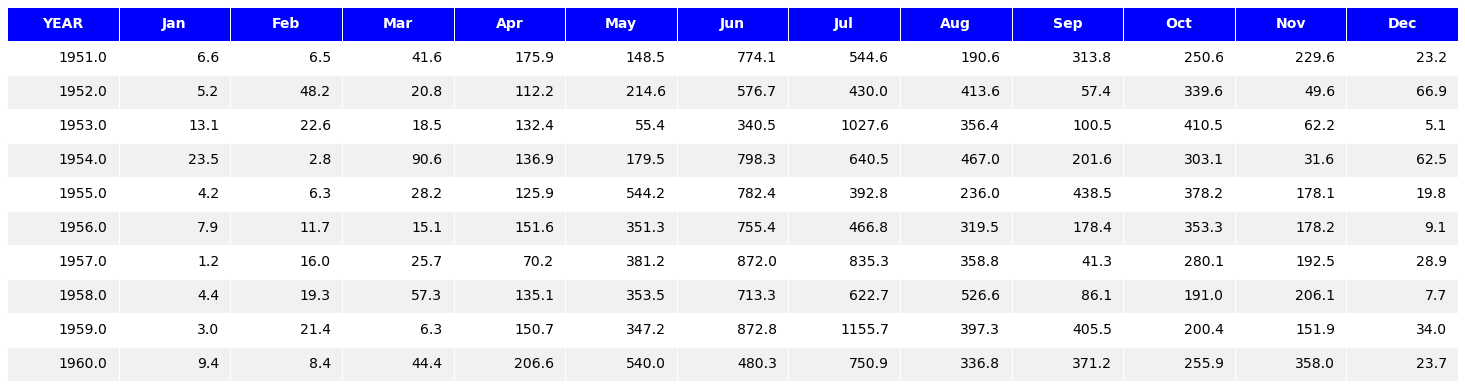

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six


def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#0000ff', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(rainfall_data_matrix.head(10).round(3), header_columns=0, col_width=2.0)

In [25]:
rainfall_data_matrix.set_index('YEAR', inplace=True)
rainfall_data_matrix.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
YEAR,,,,,,,,,,,,
1951,6.6,6.5,41.6,175.9,148.5,774.1,544.6,190.6,313.8,250.6,229.6,23.2
1952,5.2,48.2,20.8,112.2,214.6,576.7,430.0,413.6,57.4,339.6,49.6,66.9
1953,13.1,22.6,18.5,132.4,55.4,340.5,1027.6,356.4,100.5,410.5,62.2,5.1
1954,23.5,2.8,90.6,136.9,179.5,798.3,640.5,467.0,201.6,303.1,31.6,62.5
1955,4.2,6.3,28.2,125.9,544.2,782.4,392.8,236.0,438.5,378.2,178.1,19.8


In [26]:
rainfall_data_matrix = rainfall_data_matrix.transpose()
rainfall_data_matrix

YEAR,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Jan,6.6,5.2,13.1,23.5,4.2,7.9,1.2,4.4,3.0,9.4,...,18.7,9.0,0.4,0.8,3.2,18.4,20.6,7.4,3.9,4.6
Feb,6.5,48.2,22.6,2.8,6.3,11.7,16.0,19.3,21.4,8.4,...,6.6,0.6,5.6,29.7,1.3,1.0,46.1,9.1,40.1,10.3
Mar,41.6,20.8,18.5,90.6,28.2,15.1,25.7,57.3,6.3,44.4,...,25.8,80.1,8.0,216.0,64.2,31.9,25.3,29.6,49.9,17.9
Apr,175.9,112.2,132.4,136.9,125.9,151.6,70.2,135.1,150.7,206.6,...,202.9,73.0,143.4,103.7,67.8,140.3,165.2,197.5,49.3,95.7
May,148.5,214.6,55.4,179.5,544.2,351.3,381.2,353.5,347.2,540.0,...,137.3,521.2,202.7,78.6,190.4,189.8,121.6,83.8,119.3,251.0
Jun,774.1,576.7,340.5,798.3,782.4,755.4,872.0,713.3,872.8,480.3,...,634.9,577.1,737.4,478.0,433.6,669.1,790.5,444.6,1042.7,454.4
Jul,544.6,430.0,1027.6,640.5,392.8,466.8,835.3,622.7,1155.7,750.9,...,877.1,569.4,996.1,508.7,927.5,630.0,538.4,360.6,830.2,677.8
Aug,190.6,413.6,356.4,467.0,236.0,319.5,358.8,526.6,397.3,336.8,...,301.4,396.4,502.5,347.8,270.3,358.3,495.3,502.6,369.7,733.9
Sep,313.8,57.4,100.5,201.6,438.5,178.4,41.3,86.1,405.5,371.2,...,431.3,481.2,550.2,343.9,327.6,273.8,391.9,240.0,318.6,298.8
Oct,250.6,339.6,410.5,303.1,378.2,353.3,280.1,191.0,200.4,255.9,...,250.5,374.8,366.1,354.1,210.1,442.5,230.9,189.3,259.9,355.5


<AxesSubplot:>

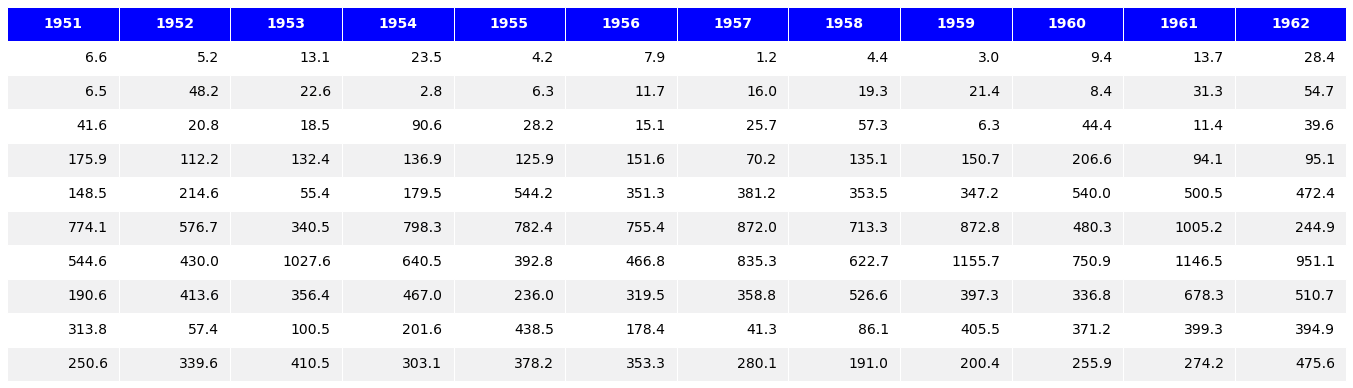

In [27]:
render_mpl_table(rainfall_data_matrix.iloc[:,0:12].head(10).round(3), header_columns=0, col_width=2.0)

In [28]:
dates = pd.date_range(start='1951-01', freq='MS', periods=len(rainfall_data_matrix.columns)*12)
dates

DatetimeIndex(['1951-01-01', '1951-02-01', '1951-03-01', '1951-04-01',
               '1951-05-01', '1951-06-01', '1951-07-01', '1951-08-01',
               '1951-09-01', '1951-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=768, freq='MS')

Text(0.5, 1.0, 'Month vs mean precipitation across all years')

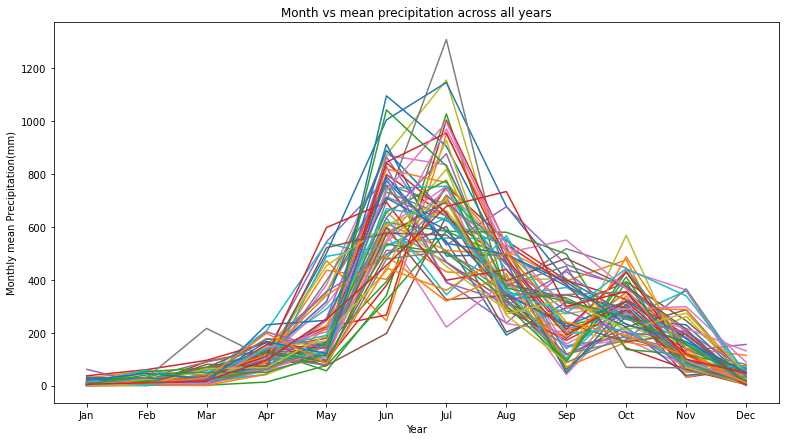

In [29]:
plt.figure(figsize=(13,7))
plt.plot(rainfall_data_matrix)
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Month vs mean precipitation across all years')

Text(0.5, 1.0, 'Month vs Precipitation across all years')

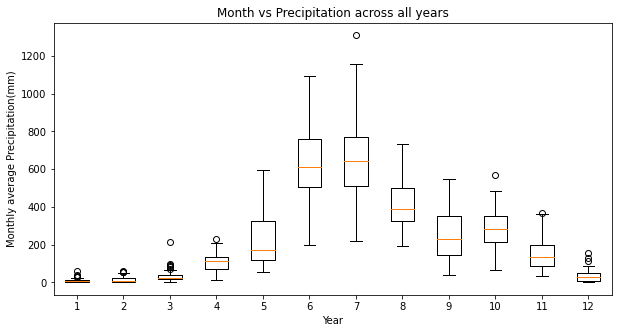

In [30]:
plt.figure(figsize=(10,5))
plt.boxplot(rainfall_data_matrix.transpose())
plt.xlabel('Year')
plt.ylabel('Monthly average Precipitation(mm)')
plt.title('Month vs Precipitation across all years')

In [31]:
average_rainfall_year = pd.DataFrame({'average_rainfall_year': rainfall_data_matrix.mean(axis=0)})
average_rainfall_year = average_rainfall_year.transpose()
average_rainfall_year.head()

YEAR,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
average_rainfall_year,225.466667,194.566667,212.066667,244.825,261.216667,233.191667,258.6,243.591667,312.183333,282.133333,...,262.583333,274.808333,301.625,211.183333,234.658333,261.833333,253.466667,182.3,271.291667,253.883333


Text(0.5, 1.0, 'Year vs Average Precipitation')

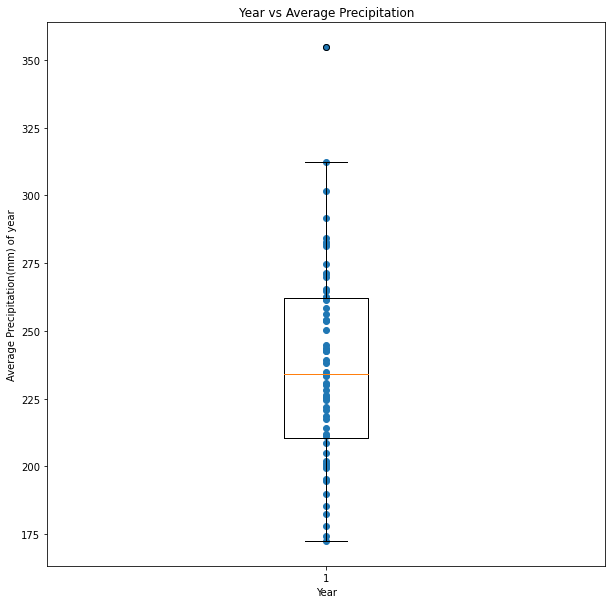

In [32]:
plt.figure(figsize=(10,10))
plt.boxplot(average_rainfall_year.transpose())
plt.scatter(x=[1] * len(average_rainfall_year.iloc[0]), y=average_rainfall_year.iloc[0])
plt.xlabel('Year')
plt.ylabel('Average Precipitation(mm) of year')
plt.title('Year vs Average Precipitation')

In [33]:
rainfall_data_matrix_np = rainfall_data_matrix.transpose().values

shape = rainfall_data_matrix_np.shape
rainfall_data_matrix_np = rainfall_data_matrix_np.reshape((shape[0] * shape[1], 1))

In [72]:
rainfall_data = pd.DataFrame({'Precipitation': rainfall_data_matrix_np[:,0]})
rainfall_data.set_index(dates, inplace=True)

test_rainfall_data = rainfall_data.loc['2002':'2014']
rainfall_data = rainfall_data.loc[:'2001']
test_rainfall_data.head()

,Precipitation
2002-01-01,6.6
2002-02-01,9.8
2002-03-01,34.5
2002-04-01,116.9
2002-05-01,340.7


Text(0.5, 1.0, 'Monthly mean Precipitation(mm) across years')

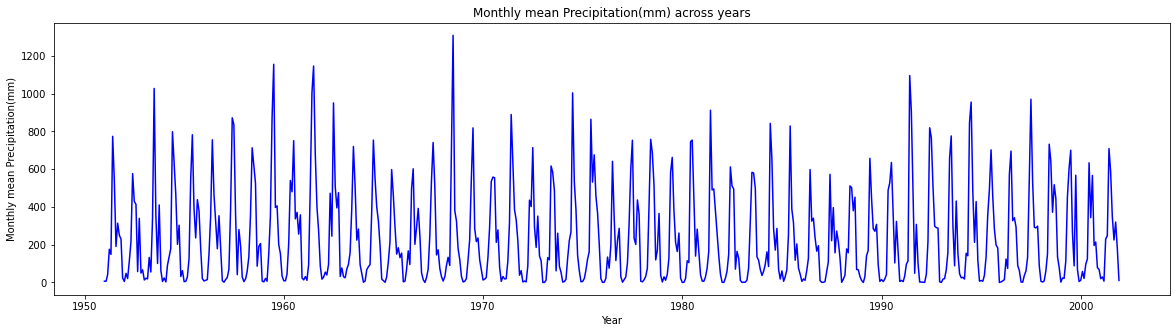

In [73]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Monthly mean Precipitation(mm) across years')

Text(0.5, 1.0, 'Monthly mean Precipitation(mm) across years')

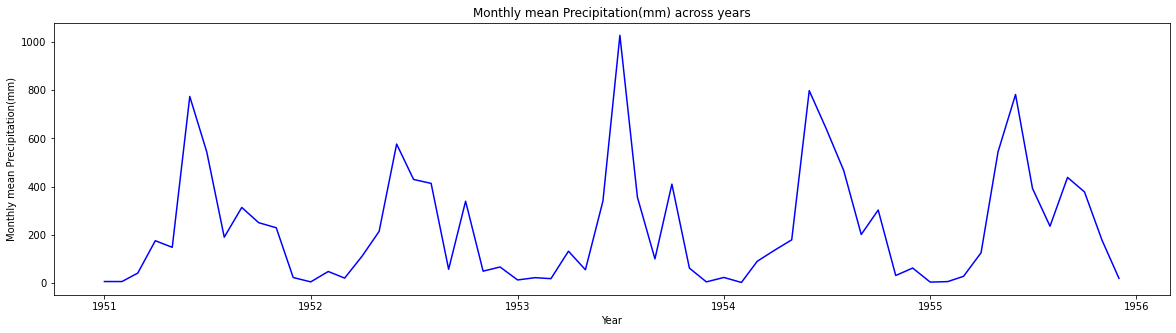

In [74]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data.iloc[:60], color='blue')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Monthly mean Precipitation(mm) across years')

In [75]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(rainfall_data, model='additive')

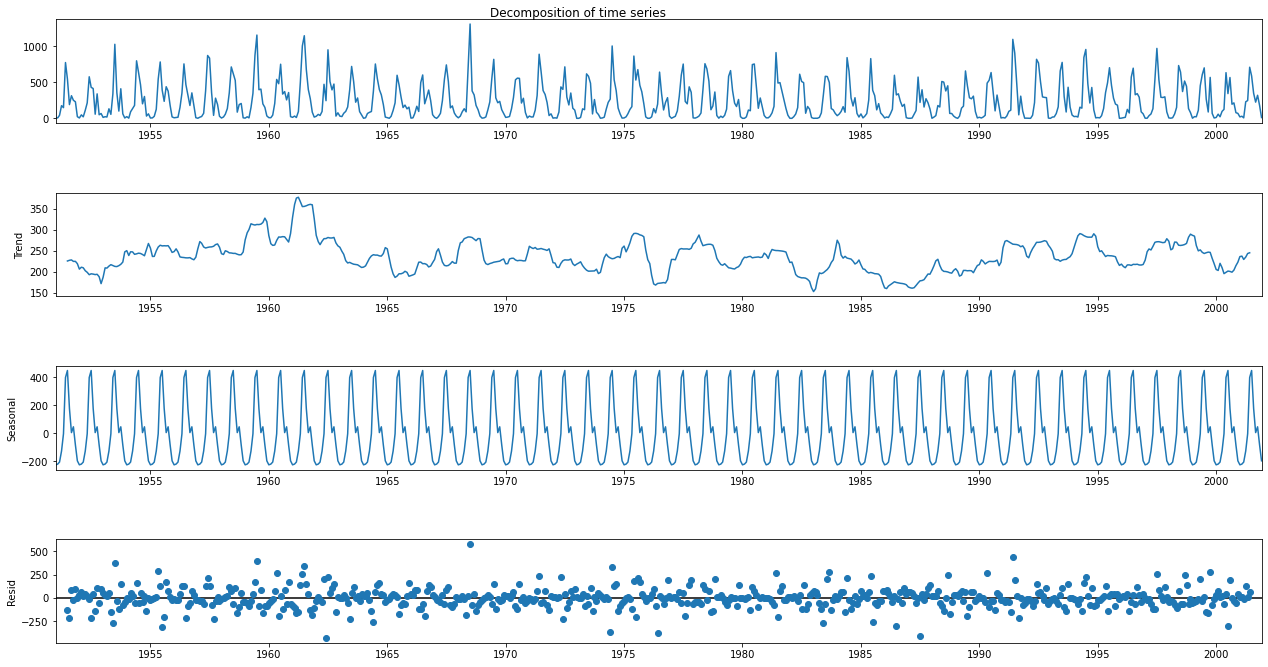

In [76]:
fig = decomposition.plot()
fig.set_figwidth(20)
fig.set_figheight(10)
fig.suptitle('Decomposition of time series')
plt.show()

Text(0.5, 1.0, '4 Months Moving Average')

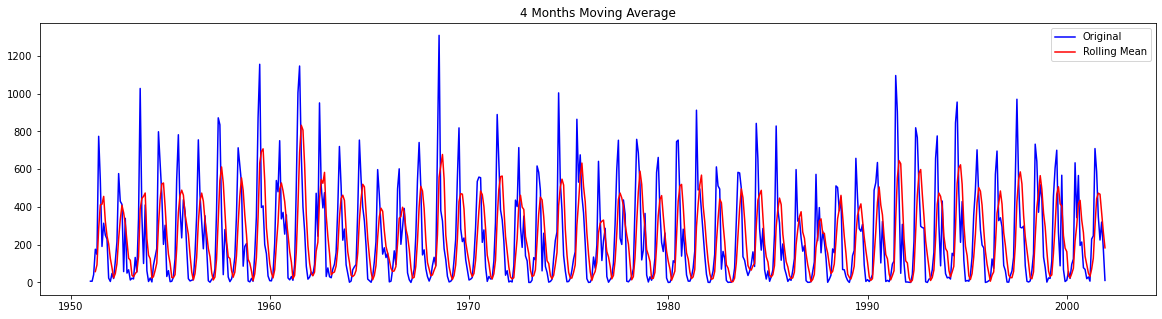

In [77]:
plt.figure(figsize=(20,5))
four_months_moving_average = rainfall_data.rolling(window=4).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(four_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('4 Months Moving Average')

Text(0.5, 1.0, '6 Months Moving Average')

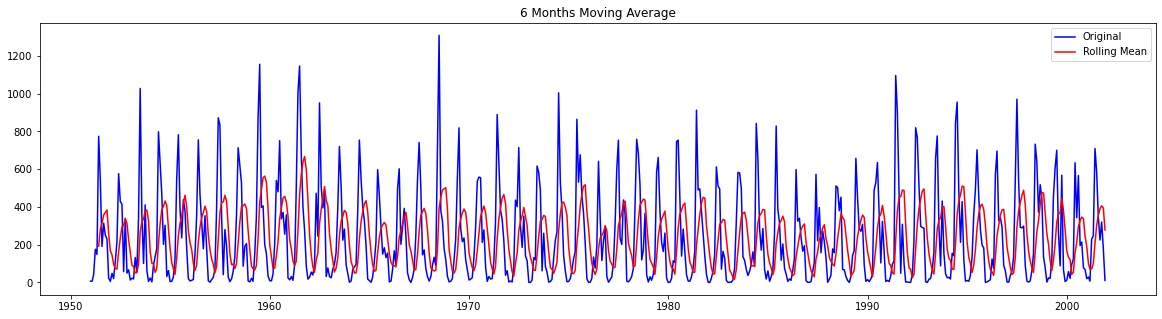

In [78]:
plt.figure(figsize=(20,5))
six_months_moving_average = rainfall_data.rolling(window=6).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(six_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('6 Months Moving Average')

Text(0.5, 1.0, '8 Months Moving Average')

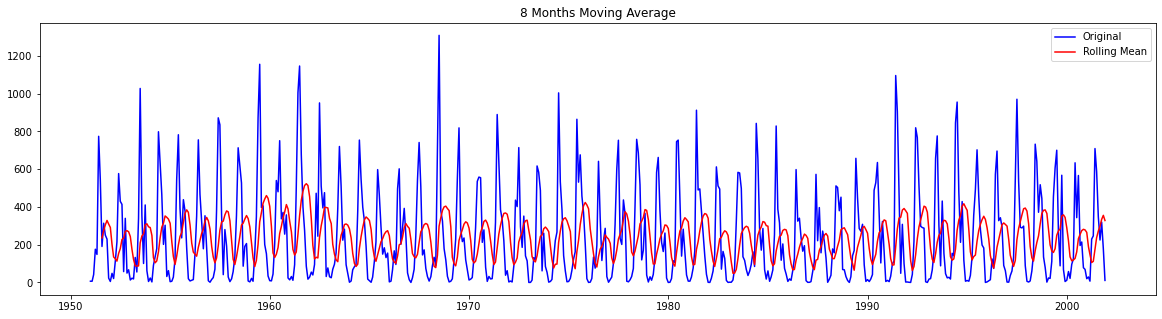

In [79]:
plt.figure(figsize=(20,5))
eight_months_moving_average = rainfall_data.rolling(window=8).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(eight_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('8 Months Moving Average')

Text(0.5, 1.0, '12 Months Moving Average')

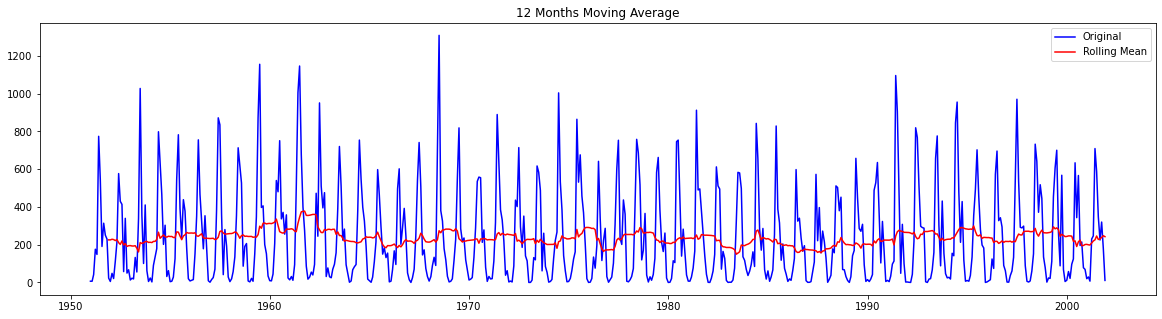

In [80]:
plt.figure(figsize=(20,5))
twelve_months_moving_average = rainfall_data.rolling(window=12).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(twelve_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('12 Months Moving Average')

In [81]:
def test_stationary(timeseries, window=12):
    
    # Rolling statistics
    movingAverage = timeseries.rolling(window=window).mean()
    movingSTD = timeseries.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(20,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation\n')
    plt.show(block=False)
    
    # Dickey Fuller test
    print('Results of Dickey Fuller Test:\n')
    dftest = adfuller(timeseries['Precipitation'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

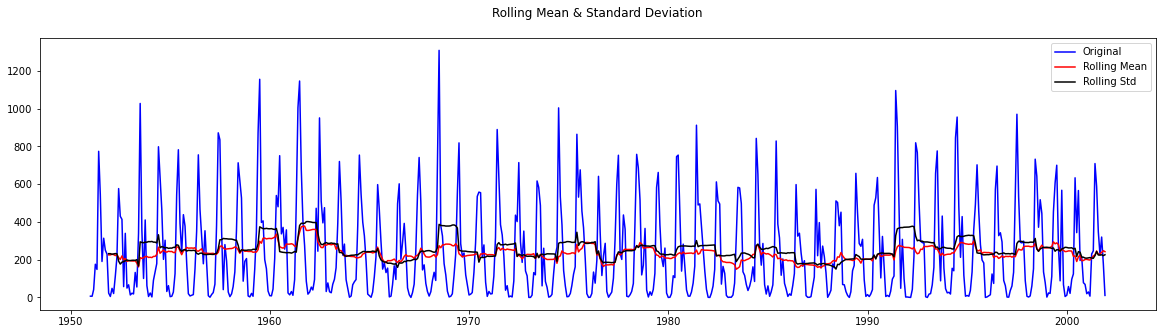

Results of Dickey Fuller Test:

Test Statistic                  -4.440031
p-value                          0.000252
No. of Lags used                13.000000
Number of observations used    598.000000
Critical Value (1%)             -3.441333
Critical Value (5%)             -2.866385
Critical Value (10%)            -2.569350
dtype: float64


In [82]:
test_stationary(rainfall_data, window=12)

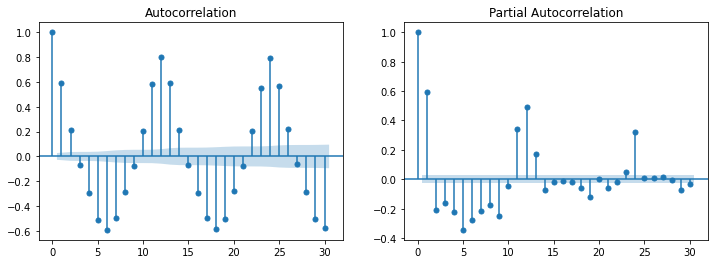

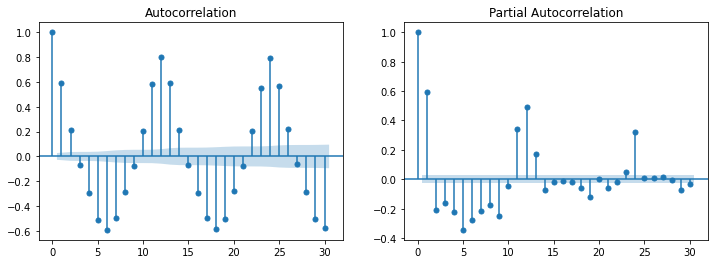

In [83]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
sm.graphics.tsa.plot_acf(rainfall_data, lags=30, ax=axes[0], alpha=0.5)
sm.graphics.tsa.plot_pacf(rainfall_data, lags=30, ax=axes[1], alpha=0.5)

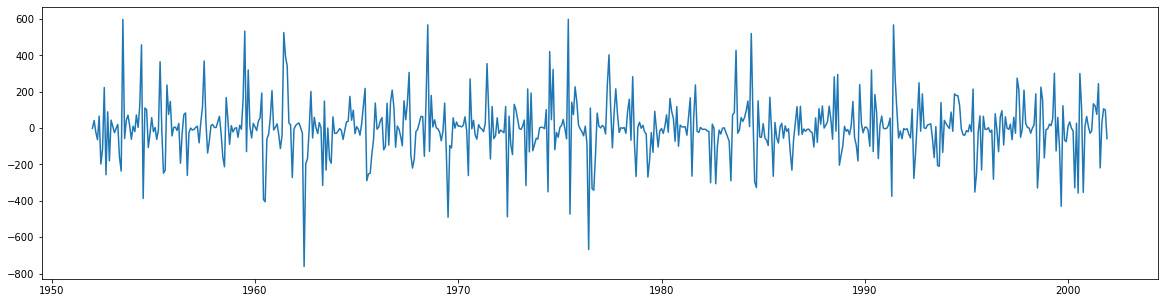

In [84]:
diff_12 = rainfall_data.diff(periods=12)
diff_12.dropna(inplace=True)

plt.figure(figsize=(20,5))
plt.plot(diff_12)

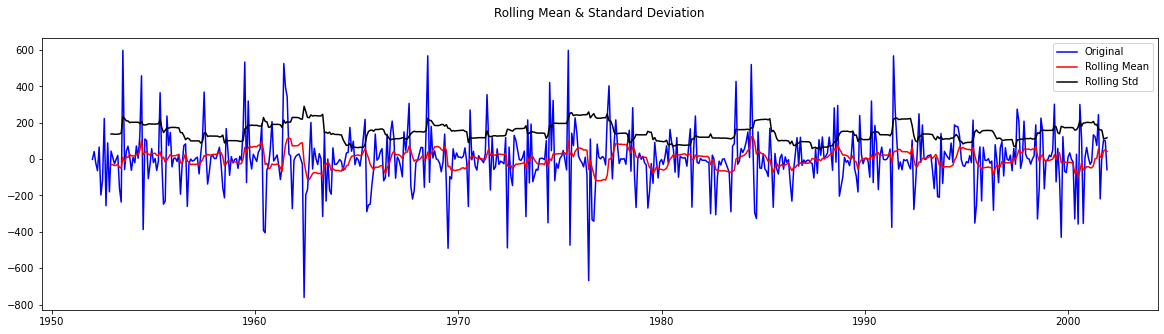

Results of Dickey Fuller Test:

Test Statistic                -9.553924e+00
p-value                        2.528535e-16
No. of Lags used               1.200000e+01
Number of observations used    5.870000e+02
Critical Value (1%)           -3.441539e+00
Critical Value (5%)           -2.866476e+00
Critical Value (10%)          -2.569399e+00
dtype: float64


In [85]:
test_stationary(diff_12)

In [86]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [87]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [88]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [89]:
AIC_scores_list = []

In [90]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:        
        try:
            
            temp_model = sm.tsa.statespace.SARIMAX(rainfall_data,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()
            l = []
            l.append(param[0])
            l.append(param[1])
            l.append(param[2])
            l.append(param_seasonal[0])
            l.append(param_seasonal[1])
            l.append(param_seasonal[2])
            l.append(param_seasonal[3])
            l.append(results.aic)
            AIC_scores_list.append(l)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 model - AIC:7442.410347100202


In [91]:
AIC_scores = pd.DataFrame.from_records(AIC_scores_list)
AIC_scores.columns=['p', 'd', 'q', 'P', 'D', 'Q', 's', 'AIC']
AIC_scores.iloc[AIC_scores['AIC'].argmin()]

p         0.000000
d         0.000000
q         0.000000
P         1.000000
D         1.000000
Q         1.000000
s        12.000000
AIC    7442.410347
Name: 7, dtype: float64

<AxesSubplot:>

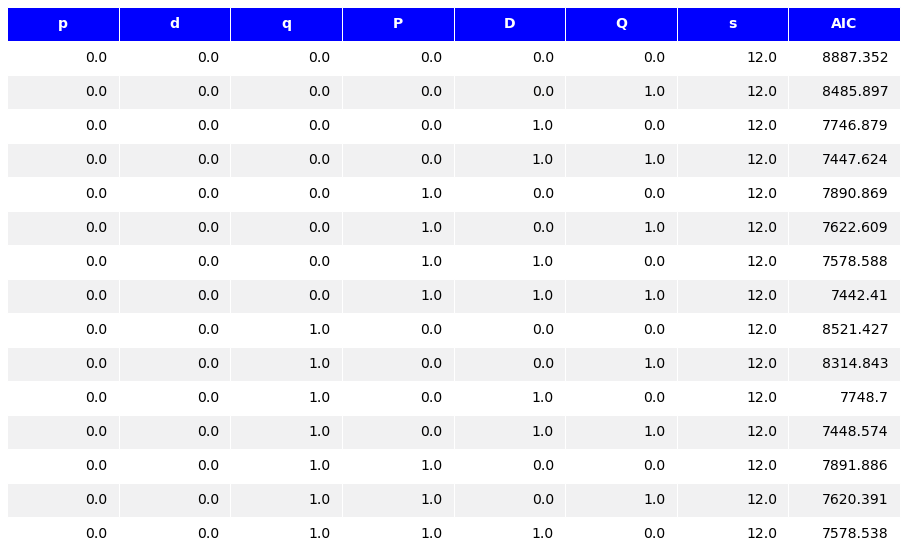

In [92]:
AIC_scores.head(15)
render_mpl_table(AIC_scores.head(15).round(3), header_columns=0, col_width=2.0)

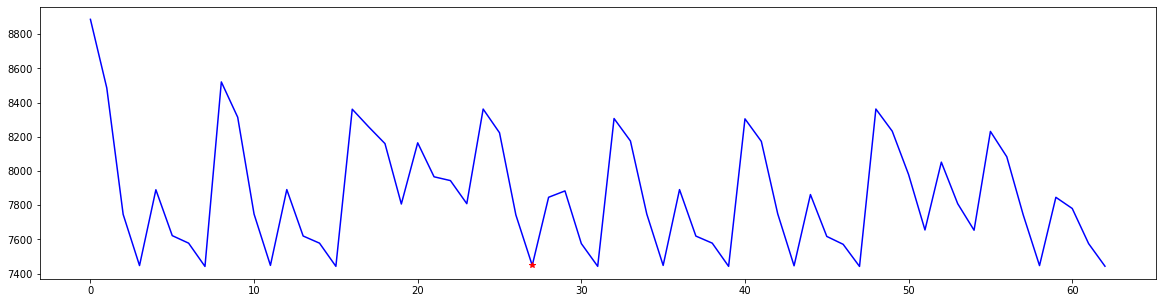

In [93]:
plt.figure(figsize=(20,5))
plt.plot(AIC_scores.AIC, color='blue')
plt.plot(27, AIC_scores.AIC[27], 'r*')

In [94]:
best_pdq = (0, 1, 1)
best_seasonal_pdq = (0, 1, 1, 12)

In [95]:
best_model = sm.tsa.statespace.SARIMAX(rainfall_data,
                                      order=best_pdq,
                                      seasonal_order=best_seasonal_pdq,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [96]:
print(best_results.summary().tables[0])

                                     SARIMAX Results                                      
Dep. Variable:                      Precipitation   No. Observations:                  612
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3721.188
Date:                            Tue, 07 Jun 2022   AIC                           7448.376
Time:                                    10:32:32   BIC                           7461.562
Sample:                                01-01-1951   HQIC                          7453.510
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         


In [97]:
pd.to_datetime('2000-01-01')

Timestamp('2000-01-01 00:00:00')

In [98]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('1990-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [99]:
rainfall_predicted = pred_dynamic.predicted_mean
rainfall_truth = rainfall_data['2000':].Precipitation

In [100]:
mse = math.sqrt(((rainfall_predicted - rainfall_truth) ** 2).mean())
print('The Mean Squared Error of our predictions is {}'.format(round(mse, 4)))

The Mean Squared Error of our predictions is 86.8063


In [101]:
rainfall_data.index[-1]

Timestamp('2001-12-01 00:00:00', freq='MS')

In [102]:
rainfall_dummy_data = rainfall_data
rainfall_dummy_data.columns = ['Train data']

1999-01-01    -22.455842
1999-02-01    -18.737538
1999-03-01     -1.588053
1999-04-01     73.856860
1999-05-01    172.239961
1999-06-01    588.020474
1999-07-01    582.434911
1999-08-01    373.176497
1999-09-01    212.812460
1999-10-01    213.984961
1999-11-01    118.363294
1999-12-01      7.146682
2000-01-01    -23.814554
2000-02-01    -20.096250
2000-03-01     -2.946766
2000-04-01     72.498147
2000-05-01    170.881248
2000-06-01    586.661762
2000-07-01    581.076199
2000-08-01    371.817784
2000-09-01    211.453747
2000-10-01    212.626248
2000-11-01    117.004581
2000-12-01      5.787969
2001-01-01    -25.173267
2001-02-01    -21.454963
2001-03-01     -4.305479
2001-04-01     71.139434
2001-05-01    169.522535
2001-06-01    585.303049
2001-07-01    579.717486
2001-08-01    370.459071
2001-09-01    210.095035
2001-10-01    211.267536
2001-11-01    115.645868
2001-12-01      4.429257
Freq: MS, Name: predicted_mean, dtype: float64

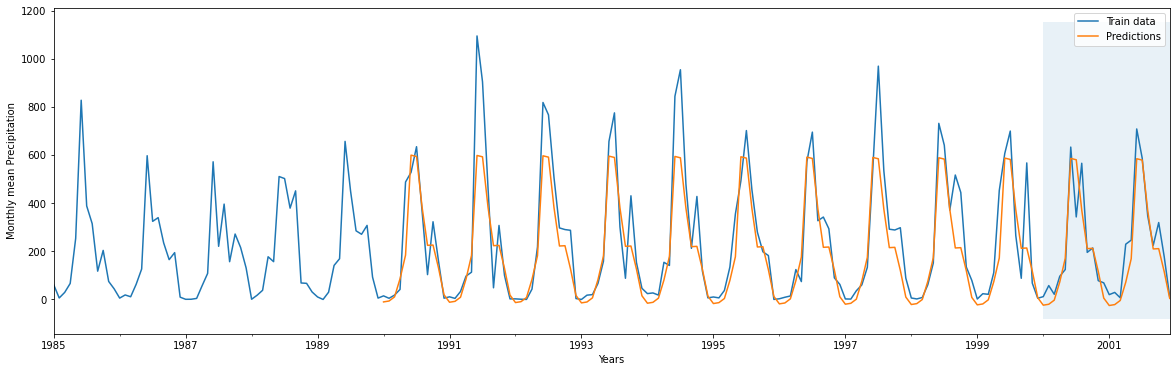

In [103]:
# Plot the actual values.
axis_plt = rainfall_dummy_data['1985':].plot(label='Train data', figsize=(20, 6))

# Plot the predicted values.
pred_dynamic.predicted_mean.plot(ax=axis_plt, label='Predictions')

# Plot confidence values and fill it with some colour.
# axis_plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.1)
axis_plt.fill_betweenx(axis_plt.get_ylim(), pd.to_datetime('2000'), rainfall_data.index[-1], alpha=0.1, zorder=-1)

# Set labels.
axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')

# Put legend on the plot at the best place it fits.
plt.legend(loc='best')
pred_dynamic.predicted_mean.tail(36)

In [115]:
# Get forecast 156 steps (13 years) ahead in future
n_steps = 150
pred_uc_95 = best_results.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% of the forecasts
pred_ci_95 = pred_uc_95.conf_int()

In [120]:
from datetime import datetime  
from datetime import timedelta  
index = pd.date_range(rainfall_data.index[-1]+timedelta(days=1) , periods=n_steps, freq='MS')
forecast_data = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=index, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

forecast_data.tail(20)


,forecast,lower_ci_95,upper_ci_95
2012-11-01,142.888586,-90.930872,376.708043
2012-12-01,28.725394,-205.094289,262.545076
2013-01-01,1.095965,-233.136714,235.328644
2013-02-01,7.032070,-227.200802,241.264943
2013-03-01,16.733845,-217.499215,250.966904
2013-04-01,98.231418,-136.001829,332.464666
2013-05-01,203.627956,-30.605479,437.861390
2013-06-01,640.356743,406.123121,874.590365
2013-07-01,651.959449,417.725639,886.193258
2013-08-01,401.861852,167.627855,636.095849


,Train data
1951-01-01,6.6
1951-02-01,6.5
1951-03-01,41.6
1951-04-01,175.9
1951-05-01,148.5
...,...
1958-12-01,7.7
1959-01-01,3.0
1959-02-01,21.4
1959-03-01,6.3


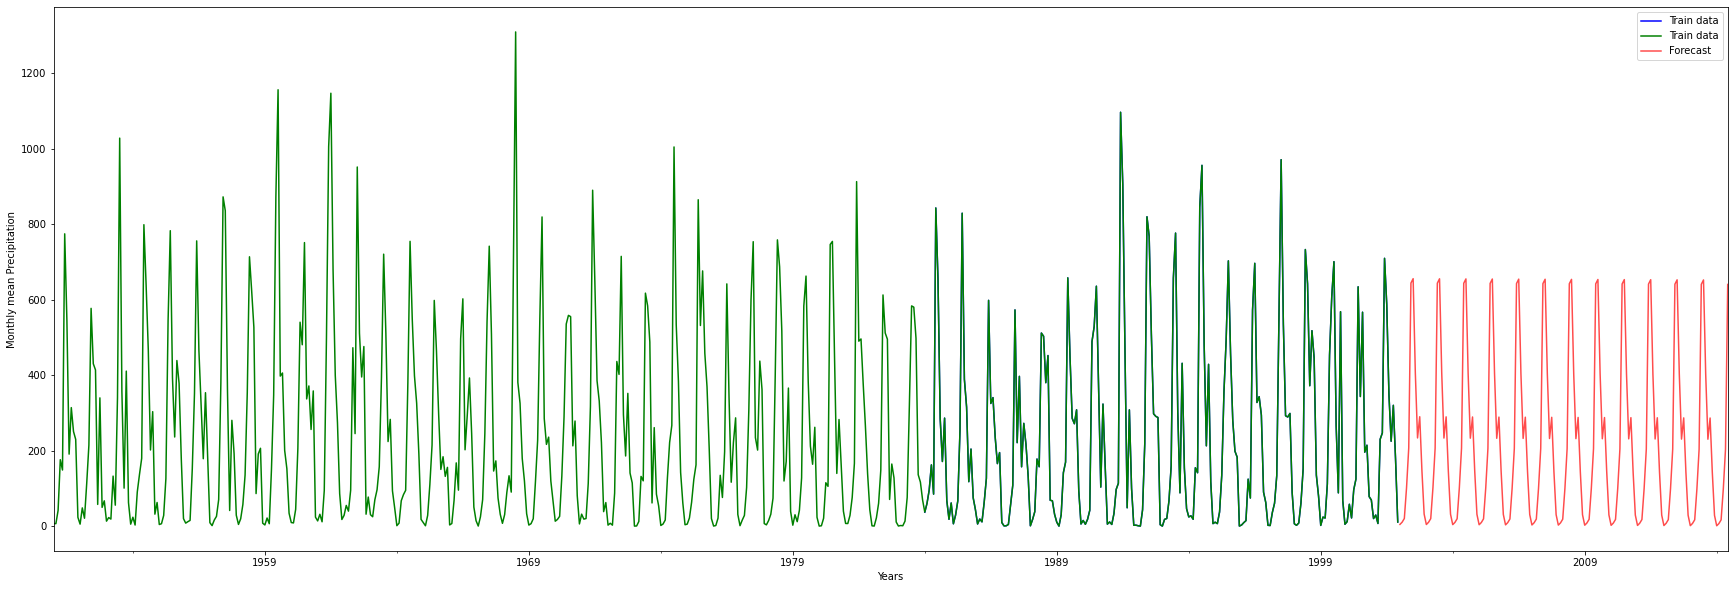

In [117]:
axis_plt = rainfall_dummy_data['1984':].plot(label='Observed', color='blue', figsize=(30,10))
rainfall_data.plot(ax=axis_plt, color='green', label='Test data')
forecast_data['forecast']['1996':].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

axis_plt.set_xlabel('Years')
axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')
plt.legend(loc='best')
rainfall_data.head(100)

In [118]:
dummy_test_data = test_rainfall_data
dummy_test_data.columns = ['Test data']

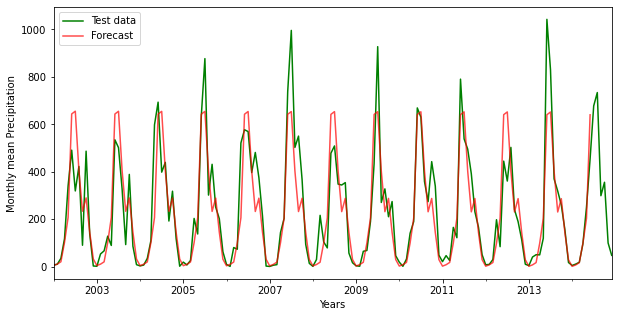

In [119]:
axis_plt = dummy_test_data['1996':].plot(label='Actual values', figsize=(10, 5), color='green')
forecast_data['forecast']['1996':].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

In [107]:
y_true = test_rainfall_data['1995-01-01':]['Test data']
y_forecast = forecast_data['forecast']

In [108]:
mse = math.sqrt(((y_true - y_forecast) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is nan
